<a href="https://colab.research.google.com/github/meghansh36/parkinson/blob/master/parkinson_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1FA0IcN6Ohla_99F5nuyK32Xj209HSi7l'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Spiral_HandPD.zip')

In [0]:
from pathlib import Path

In [0]:
p = Path('/content/Spiral_HandPD.zip')

In [0]:
import zipfile
zip_ref = zipfile.ZipFile(p, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [0]:
p = Path('/content/data')
p.ls()
import shutil
shutil.rmtree(p/"__MACOSX")

In [52]:
p_control = p/"SpiralControl"
p_control

PosixPath('/content/data/SpiralControl')

In [0]:
p_patient = p/"SpiralPatients"

In [54]:
p_control

PosixPath('/content/data/SpiralControl')

In [55]:
str(p_control)

'/content/data/SpiralControl'

In [0]:
p_control.ls()

In [0]:
import pandas as pd
df = pd.DataFrame(columns=["name", "label"])

In [0]:
for i in p_control.ls():
  file_path = str(i)
  
  filename = file_path.split('/')[-1]
  if filename == ".DS_Store":
    continue
  df2 = pd.DataFrame([["SpiralControl/"+filename, 0]], columns=["name","label"])
  df = df.append(df2, ignore_index=True)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_df(path=p,df=df, size=128)
data = data.normalize(imagenet_stats)

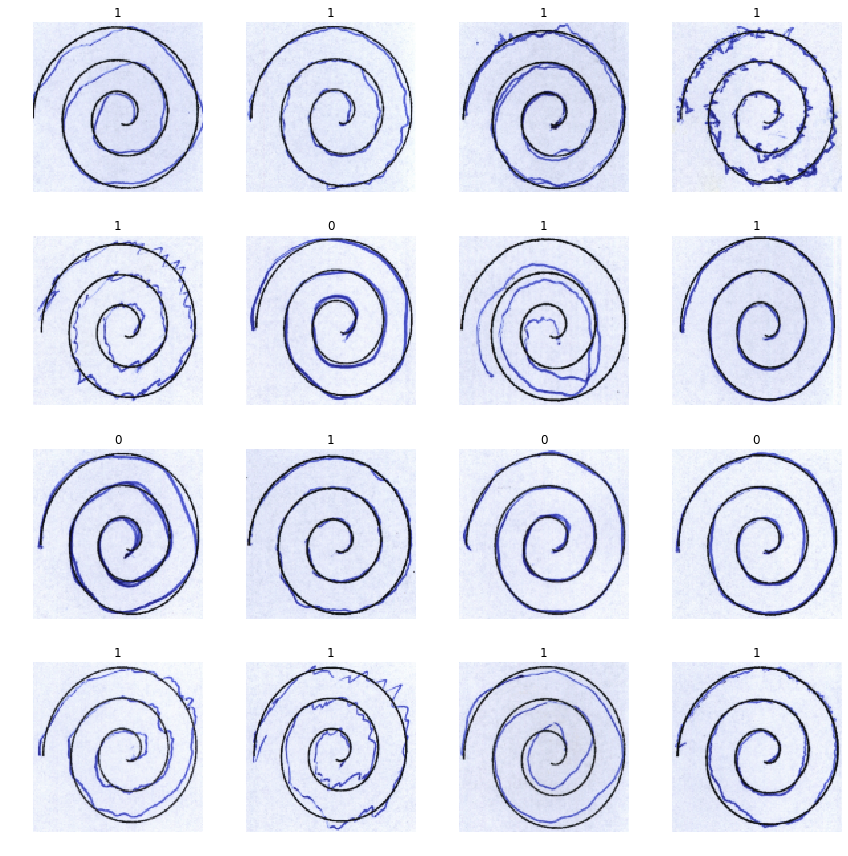

In [62]:
data.show_batch(rows=4, figsize=(12,12))

In [64]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, path="/content")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 97166440.17it/s]


In [0]:
learn


In [65]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.902291,0.554751,0.808219,00:07
1,0.737314,0.931714,0.424658,00:06
2,0.582999,0.594403,0.726027,00:06
3,0.483684,0.582226,0.739726,00:06
4,0.411921,0.634681,0.753425,00:06


In [0]:
learn.save("stage-1")
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_top_losses(9, heatmap=False, figsize=(12,12))

In [0]:
# learn.load("stage-1")
learn.unfreeze()

In [68]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


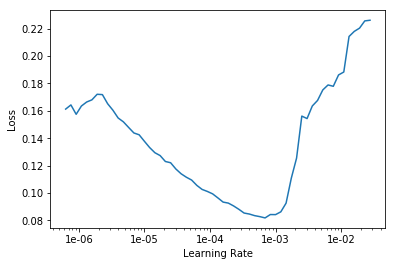

In [69]:
learn.recorder.plot()

In [70]:
learn.fit_one_cycle(8, max_lr=slice(1e-05,1e-03/3))

epoch,train_loss,valid_loss,accuracy,time
0,0.198369,0.684052,0.753425,00:05
1,0.149151,0.763927,0.726027,00:06
2,0.115759,0.652524,0.753425,00:06
3,0.099821,0.492079,0.835616,00:06
4,0.085587,0.371353,0.863014,00:06
5,0.071662,0.254755,0.917808,00:06
6,0.062304,0.194644,0.904110,00:07
7,0.054544,0.168697,0.917808,00:07


In [0]:
learn.save("stage-2")


In [0]:
learn.load("stage-2")

In [0]:
# Size gradually increased to 224x224
data = ImageDataBunch.from_df(path=p,df=df, size=224, bs=64)
data = data.normalize(imagenet_stats)

In [0]:
learn.data = data

In [0]:
learn.freeze()

In [75]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


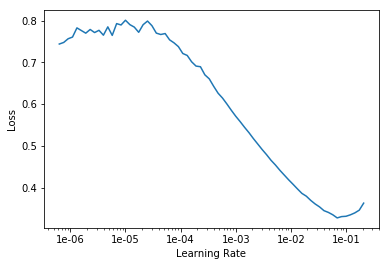

In [76]:
learn.recorder.plot()


In [77]:
learn.fit_one_cycle(8, max_lr=slice(1e-04,1e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.642062,0.658320,0.808219,00:09
1,0.412463,0.390648,0.821918,00:09
2,0.287533,0.398466,0.821918,00:09
3,0.213359,0.413837,0.876712,00:10
4,0.171421,0.291281,0.849315,00:09
5,0.138459,0.237145,0.890411,00:09
6,0.114452,0.224028,0.931507,00:09
7,0.096646,0.219115,0.917808,00:09


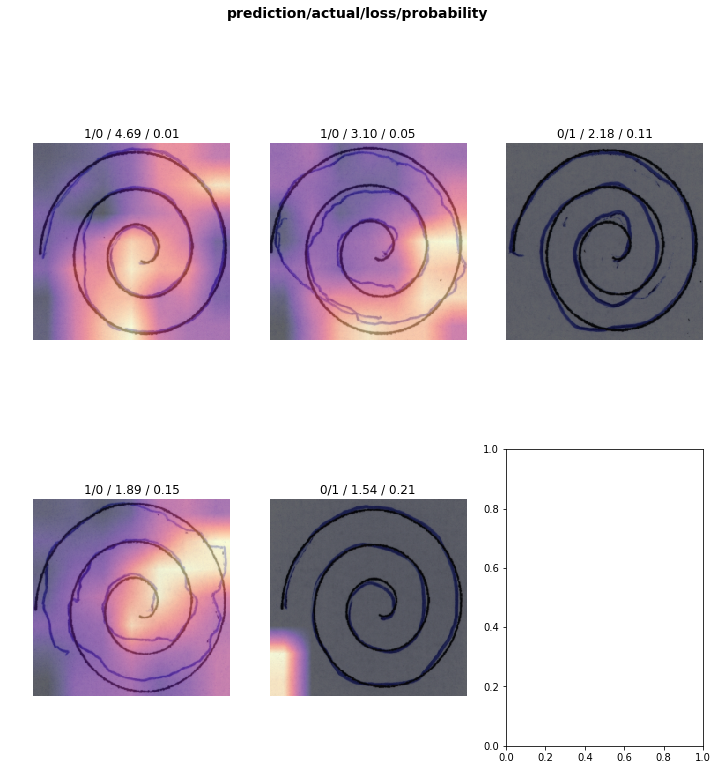

In [78]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5)

In [0]:
learn.save("stage-3-freeze")
learn.unfreeze()

In [80]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


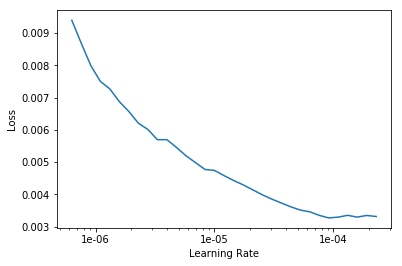

In [81]:
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.010435,0.831415,0.808219,00:10
1,0.089030,7.264347,0.479452,00:10
2,0.194882,1.081445,0.767123,00:10
3,0.196629,1.084831,0.739726,00:10
4,0.158912,0.421088,0.876712,00:10
5,0.135007,0.288878,0.890411,00:10
6,0.119579,0.214932,0.904110,00:09
7,0.101066,0.219758,0.931507,00:10


In [0]:
learn.save("stage-3-unfreeze")

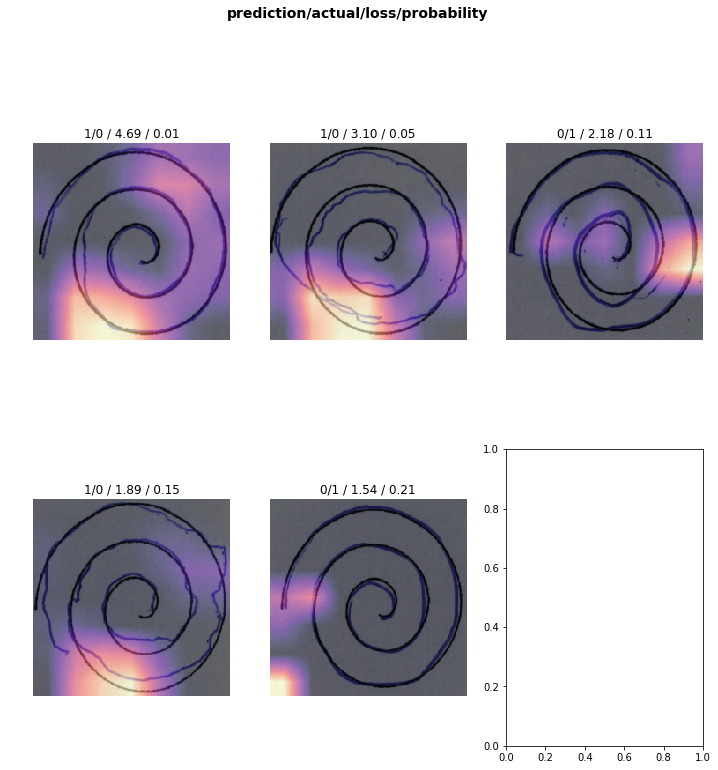

In [85]:
interp.plot_top_losses(5)

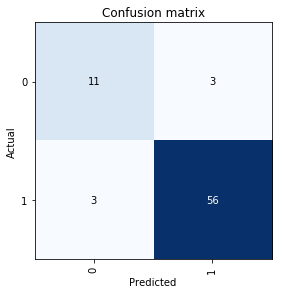

In [86]:
interp.plot_confusion_matrix()

In [0]:
learn.export()

In [0]:
learn.load('stage-3-unfreeze')

In [0]:
new_learner = nn.Sequential(*list(learn.model.children())[:-1])

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [0]:
new_learner.add_module('flatten', Flatten())

In [251]:
new_learner


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [0]:
# no need to backprop
for param in new_learner.parameters():
  param.requires_grad = False

In [0]:
img = open_image('/content/data/SpiralControl/0068-1.jpg')

In [135]:
img.apply_tfms(tfms=[],size=224)
img.shape

torch.Size([3, 224, 224])

In [253]:
learn.data

ImageDataBunch;

Train: LabelList (295 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /content/data;

Valid: LabelList (73 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /content/data;

Test: None

In [0]:
data.train_dl.batch_size = 295
inputs_train, labels_train = next(iter(data.train_dl))

In [0]:
from torch.autograd import Variable

In [0]:
inputs_train, labels_train = Variable(inputs_train), Variable(labels_train)

In [261]:
labels_train

tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1], device='cu

In [0]:
outputs = new_learner(inputs_train)

In [263]:
outputs.shape

torch.Size([295, 100352])

In [0]:
outputs_pca = outputs.pca(50)

In [265]:
outputs_pca

tensor([[-243.8757,    6.2029,  -22.7006,  ...,   -5.3895,   -1.1226,
           -0.8442],
        [   0.4360,  -71.9107,   25.2116,  ...,  -20.9044,   19.4553,
            2.4473],
        [  57.0572,  -15.4861,  -13.4529,  ...,  -11.1274,   -7.3675,
            6.6375],
        ...,
        [  34.6417,  -43.1695,   19.2967,  ...,    5.9793,   16.5023,
            2.5359],
        [  14.2940,  -66.5291,   56.3557,  ...,    9.9542,   -9.8477,
          -18.0790],
        [  43.3651,   46.1639,  -44.0757,  ...,   25.1973,    4.1440,
           -6.2988]], device='cuda:0')

In [0]:
outputs_pca = outputs_pca.cpu().detach().numpy()
labels_train = labels_train.cpu().detach().numpy()

In [0]:
labels_train = labels_train.reshape(-1,1)

In [0]:
test_df_train = pd.DataFrame.from_records(outputs_pca)


In [0]:
test_df_labels = pd.DataFrame.from_records(labels_train)


In [0]:
test_df_train.to_csv('/content/train_data.csv', index=None, header=False)

In [0]:
data.valid_dl.batch_size = 73
inputs_valid, labels_valid = next(iter(data.valid_dl))
inputs_valid, labels_valid = Variable(inputs_valid), Variable(labels_valid)


In [283]:
labels_valid

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1], device='cuda:0')

In [0]:
outputs_valid = new_learner(inputs_valid)
outputs_valid_pca = outputs_valid.pca(50)

In [0]:
outputs_valid_pca = outputs_valid_pca.cpu().detach().numpy()
labels_valid = labels_valid.cpu().detach().numpy()

In [0]:
labels_valid = labels_valid.reshape(-1,1)

In [0]:
test_df_valid = pd.DataFrame.from_records(outputs_valid_pca)
test_df_valid_labels = pd.DataFrame.from_records(labels_valid)

In [0]:
test_df_valid_labels.to_csv('/content/valid_labels.csv', index=None, header=False)